<Axes: xlabel='time'>

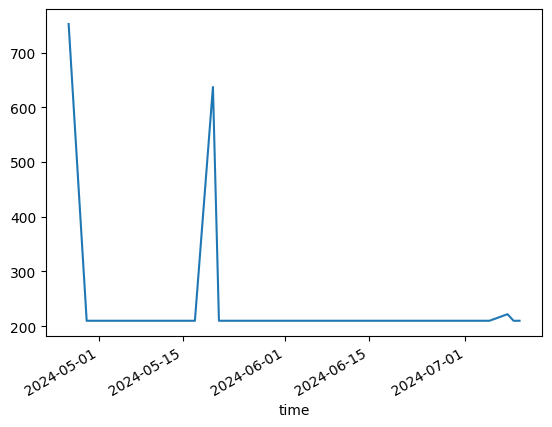

In [2]:
import pandas as pd
import numpy as np
file_path="/home/qrdutil/peoples_workspaces/yusuf-workspace/eurex/tt-stream-server-connector/FSX5E_20240101_1_20240711.csv"
eurex = pd.read_csv(file_path,index_col=0,parse_dates=True).dropna()
start_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).first()
end_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).last()
start_times.apply(lambda x: x.hour*60+x.minute).plot()

<Axes: >

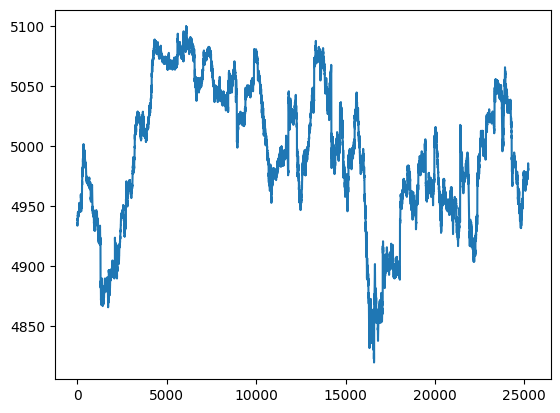

In [3]:
start_t="10:00:00"
end_t="18:00:00"
eurex=eurex.between_time(start_t,end_t)
eurex.close.reset_index(drop=True).plot()


<Axes: xlabel='time'>

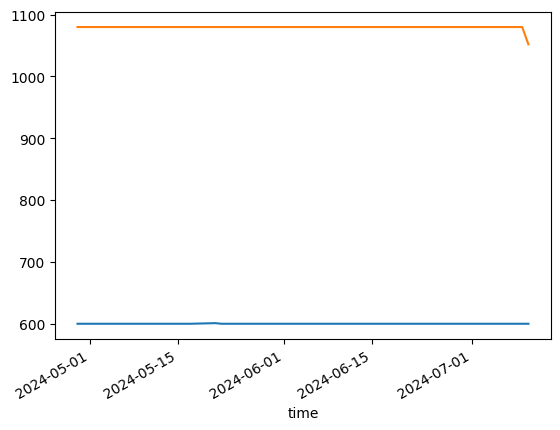

In [4]:
start_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).first()
start_times=start_times.apply(lambda x: x.hour*60+x.minute)
end_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).last()
end_times=end_times.apply(lambda x: x.hour*60+x.minute)
days_to_remove=start_times.sort_values(ascending=False).iloc[:2].index
days_to_remove=days_to_remove.union(end_times.sort_values(ascending=False).iloc[:1].index)
eurex=eurex[~eurex.index.normalize().isin(days_to_remove)]
start_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).first()
start_times=start_times.apply(lambda x: x.hour*60+x.minute)
end_times=pd.Series(eurex.index,index=eurex.index).groupby(eurex.index.normalize()).last()
end_times=end_times.apply(lambda x: x.hour*60+x.minute)
start_times.plot()
end_times.plot()

<Axes: xlabel='time'>

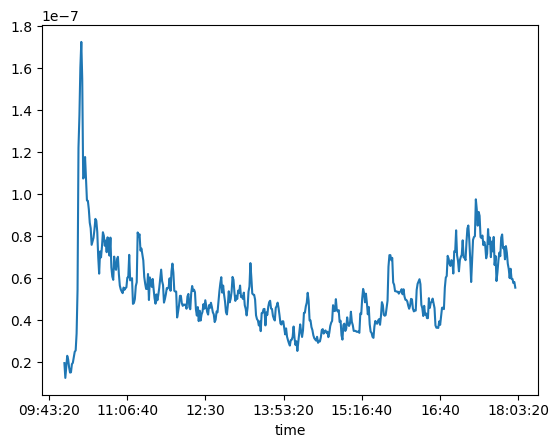

In [5]:

vol_period="5T"
eurex['vol']=0.5*(np.log(eurex.high/eurex.low)**2)-((2*np.log(2)-1)*(np.log(eurex.close/eurex.open)**2))
eurex['vol']=eurex['vol'].rolling(vol_period).mean()
eurex['vol'].groupby(eurex.index.time).median().plot()

### Intraday

<Axes: xlabel='time'>

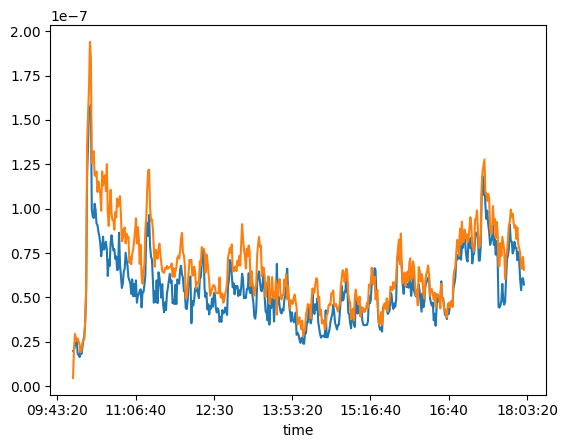

In [6]:
seasonal_period=20
vol_ssnl=eurex.vol.groupby([eurex.index.normalize(),eurex.index.time]).last().unstack()
vol_ssnl=vol_ssnl.rolling(window=seasonal_period,closed='left').median().stack(dropna=False)
new_index=vol_ssnl.index.get_level_values(0).normalize().astype(str)+' '+vol_ssnl.index.get_level_values(1).astype(str)
new_index=pd.to_datetime(new_index)
vol_ssnl.index=new_index
eurex['vol_ssnl']=vol_ssnl
eurex=eurex.dropna()
eurex.vol_ssnl.groupby(eurex.index.time).median().plot()
eurex.vol.groupby(eurex.index.time).median().plot()




<Axes: xlabel='time'>

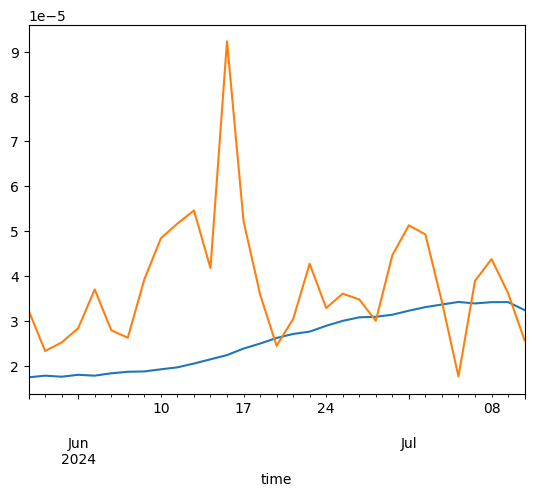

In [7]:
eurex_daily=eurex.resample('D').agg({'open':'first','high':'max','low':'min','close':'last','vol':'sum','vol_ssnl':'sum'}).dropna()
eurex_daily.vol_ssnl.plot()
eurex_daily.vol.plot()


<Axes: xlabel='time'>

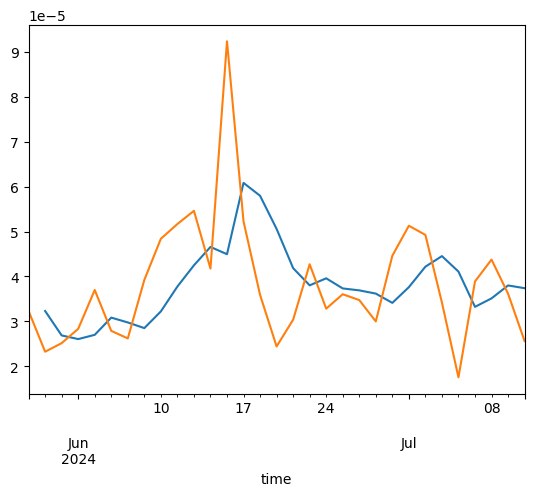

In [8]:
daily_ewm_span=2
eurex_daily['vol_sum_pred']=eurex_daily.vol.ewm(daily_ewm_span).mean()
eurex_daily['vol_sum_pred']=eurex_daily['vol_sum_pred'].shift(1)
eurex_daily.vol_sum_pred.plot()
eurex_daily.vol.plot()

<Axes: xlabel='time'>

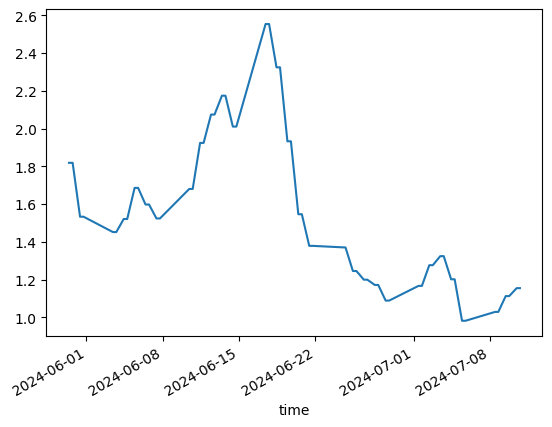

In [9]:
eurex['vol_sum_pred']=eurex.index.normalize().map(eurex_daily.vol_sum_pred)

eurex['vol_ssnl_sum']=eurex.index.normalize().map(eurex.vol_ssnl.groupby(eurex.index.normalize()).sum())
eurex['daily_pred_adj_r']=eurex.vol_sum_pred/eurex.vol_ssnl_sum
eurex['daily_pred_adj_r'].plot()


<Axes: xlabel='time'>

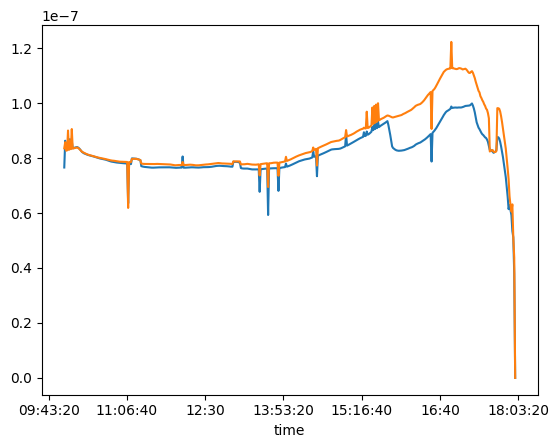

In [10]:
eurex['vol_ssnl_adj']=eurex.vol_ssnl*eurex.daily_pred_adj_r
eurex['count_to_eod']=eurex.index.normalize().map(eurex.vol.groupby(eurex.index.normalize()).count())-eurex.vol.groupby(eurex.index.normalize()).cumcount()
eurex['int_vol_eod']=eurex.index.normalize().map(eurex.vol.groupby(eurex.index.normalize()).sum())-eurex.vol.groupby(eurex.index.normalize()).cumsum()
eurex['mean_vol_eod']=eurex.int_vol_eod/eurex.count_to_eod

eurex['int_vol_eod_ssnl_adj']=eurex.index.normalize().map(eurex.vol_ssnl_adj.groupby(eurex.index.normalize()).sum())-eurex.vol_ssnl_adj.groupby(eurex.index.normalize()).cumsum()
eurex['mean_vol_eod_ssnl_adj']=eurex.int_vol_eod_ssnl_adj/eurex.count_to_eod



eurex.mean_vol_eod.groupby(eurex.index.time).mean().plot()
eurex.mean_vol_eod_ssnl_adj.groupby(eurex.index.time).mean().plot()

In [11]:
from scipy.integrate import quad
def average_spline_value(self, t):
    if not 0 <= t <= 1:
        raise ValueError("t must be between 0 and 1")

    # Integrate the spline from t to 1
    integral, _ = quad(self.seasonal_model, t, 1)
    
    # Calculate the average value
    average_value = integral / (1 - t)
    
    return average_value



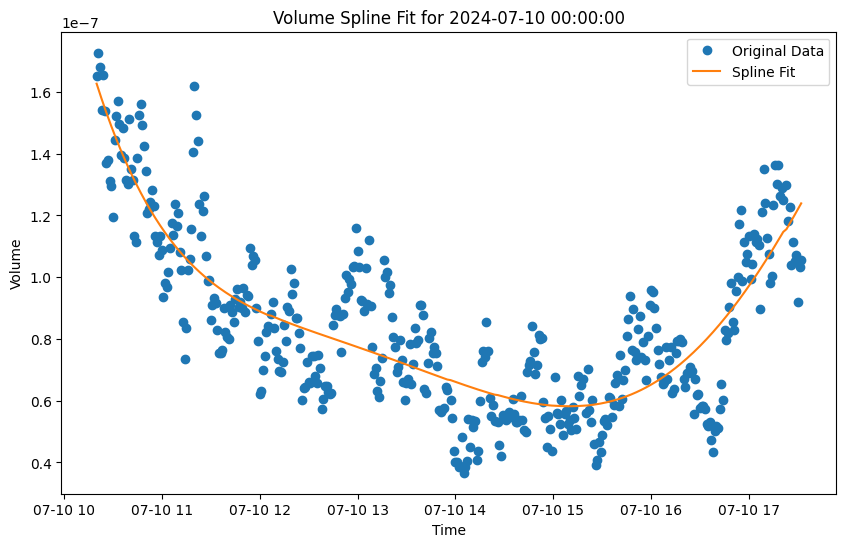

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# Assuming eurex is already defined and vol_ssnl is extracted as shown in your code
vol_ssnl = eurex.vol_ssnl_adj.between_time("10:20", "18:00")
vol_ssnl = pd.DataFrame(vol_ssnl).rename(columns={'vol_ssnl_adj': 'vol_ssnl'})
vol_ssnl['time_p'] = vol_ssnl.vol_ssnl.groupby(vol_ssnl.index.normalize()).cumcount() / vol_ssnl.index.normalize().map(vol_ssnl.vol_ssnl.groupby(vol_ssnl.index.normalize()).count())

daily_vol_ssnl_fits = []
last_day_spline = None
splines_by_day = {}

for day in vol_ssnl.index.normalize().unique():
    day_data = vol_ssnl.loc[vol_ssnl.index.normalize() == day]
    day_data = day_data.dropna()
    if day_data.shape[0] > 0:
        y = day_data.vol_ssnl
        x = day_data.time_p
        spline = UnivariateSpline(x, y, s=1,k=5)  
        yhats = spline(x)
        daily_vol_ssnl_fits.append(pd.Series(yhats, index=day_data.index))
        last_day_spline = spline
        splines_by_day[day] = spline

daily_vol_ssnl_fits = pd.concat(daily_vol_ssnl_fits)
vol_ssnl['vol_ssnl_fit'] = daily_vol_ssnl_fits

eurex['vol_ssnl_fit'] = vol_ssnl['vol_ssnl_fit']

splines_by_day=pd.DataFrame(splines_by_day,index=['spline']).T


# Plotting for a specific day
day = vol_ssnl.index.normalize().unique()[-1]
day_data = vol_ssnl.loc[vol_ssnl.index.normalize() == day]

plt.figure(figsize=(10, 6))
plt.plot(day_data.index, day_data['vol_ssnl'], 'o', label='Original Data')
plt.plot(day_data.index, day_data['vol_ssnl_fit'], label='Spline Fit')
plt.legend()
plt.title('Volume Spline Fit for ' + str(day))
plt.xlabel('Time')
plt.ylabel('Volume')
plt.show()


In [13]:
last_day_spline

def average_spline_value(model, t):
    from scipy.integrate import quad

    if not 0 <= t <= 1:
        raise ValueError("t must be between 0 and 1")

    # Integrate the spline from t to 1
    integral, _ = quad(model, t, 1)
    
    # Calculate the average value
    average_value = integral / (1 - t)
    
    return average_value

average_spline_value(last_day_spline, 0.5)

7.347476769966902e-08

<Axes: xlabel='time'>

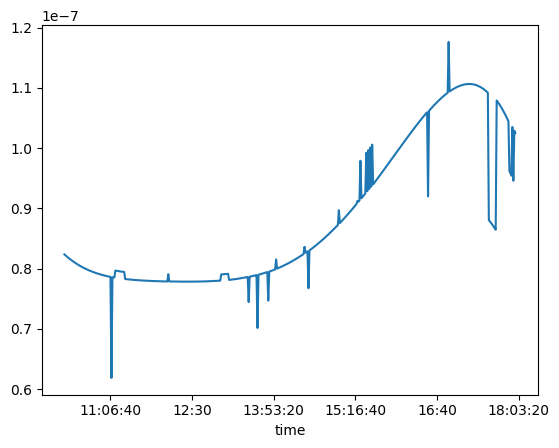

In [14]:
eurex['spline_obj']=eurex.index.normalize().map(splines_by_day.spline)
eurex['time_p']=vol_ssnl['time_p']
eurex=eurex.dropna()
eurex['mean_vol_eod_ssnl_adj']=eurex.apply(lambda x: average_spline_value(x.spline_obj,x.time_p),axis=1)
eurex.mean_vol_eod_ssnl_adj.groupby(eurex.index.time).mean().plot()

In [15]:
eurex['vol_diff']=np.log(eurex.vol).diff()
span_vals=[2,20]
X=pd.DataFrame()
for span in span_vals:
    eurex['vol_diff_ewm_'+str(span)]=eurex.vol_diff.ewm(span=span).mean()
    eurex['vol_ewm_'+str(span)]=eurex.vol.ewm(span=span).mean()
    X['vol_diff_ewm_'+str(span)]=eurex['vol_diff_ewm_'+str(span)]
    
for span in span_vals:
    eurex[f'vol_ewm_{span}_ssnl_adj_diff']=np.log(eurex[f'vol_ewm_{span}']/eurex.vol_ssnl_fit)
    X[f'vol_ewm_{span}_ssnl_adj_diff']=eurex[f'vol_ewm_{span}_ssnl_adj_diff']

X=X.shift(1).dropna()
y=np.log(eurex.mean_vol_eod/eurex.mean_vol_eod_ssnl_adj).replace([np.inf,-np.inf],np.nan).dropna()
#X=eurex[['vol_ewm_2_ssnl_adj_diff','vol_ewm_10_ssnl_adj_diff','vol_diff_ewm_10','vol_diff_ewm_2']].dropna()
#outlier elimination
"""qtl=0.7
y=y[np.abs(y)<np.abs(y).quantile(qtl)]"""

start_time="10:40:00"
end_time="18:00:00"

X=X.between_time(start_time,end_time)



common_index=X.index.intersection(y.index)

X=X.loc[common_index]
y=y.loc[common_index]


import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 

ols=sm.OLS(y_train,X_train).fit()
ols.summary()

/home/qrdutil/peoples_workspaces/yusuf-workspace/sources/ysf_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.281
Model:                            OLS   Adj. R-squared (uncentered):              0.281
Method:                 Least Squares   F-statistic:                              992.7
Date:                Tue, 16 Jul 2024   Prob (F-statistic):                        0.00
Time:                        15:39:22   Log-Likelihood:                         -4339.8
No. Observations:               10172   AIC:                                      8688.
Df Residuals:                   10168   BIC:                                      8716.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
vol_diff_ewm_2               0.5408      0.026     20.474      0.000       0.489       0.593
vol_diff_ewm_20             -6.9879      0.299    -23.363      0.000      -7.574      -6.402
vol_ewm_2_ssnl_adj_diff      0.7332      0.031     24.000      0.000       0.673       0.793
vol_ewm_20_ssnl_adj_diff    -0.3020      0.031     -9.769      0.000      -0.363      -0.241
==============================================================================
Omnibus:                      161.264   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.274
Skew:                          -0.152   Prob(JB):                     1.36e-56
Kurtosis:                       3.717   Cond. No.                         65.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='time'>

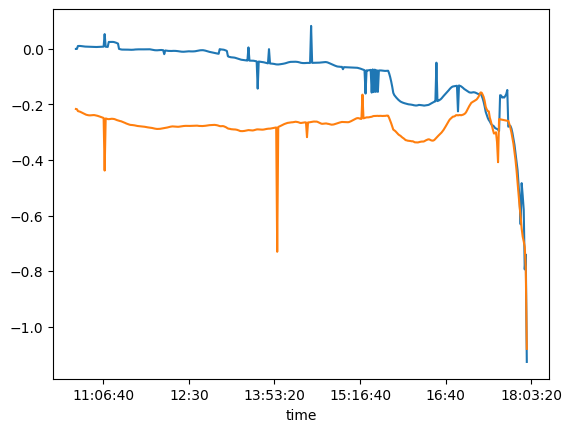

In [16]:
y_train.groupby(X_train.index.time).mean().plot()
y_test.groupby(X_test.index.time).mean().plot()

In [17]:
from sklearn.metrics import r2_score    
y_pred=ols.predict(X_test)
y_pred=pd.Series(y_pred,index=y_test.index)
r2_score(y_test,y_pred)

0.30699433057425096

<Axes: xlabel='time'>

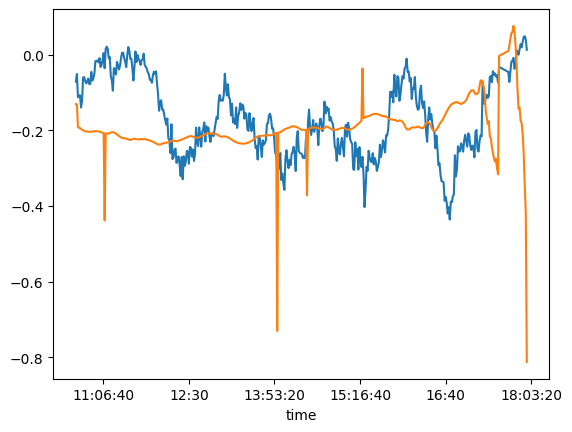

In [18]:
y_pred.groupby(X_test.index.time).median().plot()
y_test.groupby(X_test.index.time).median().plot()

<Axes: xlabel='time'>

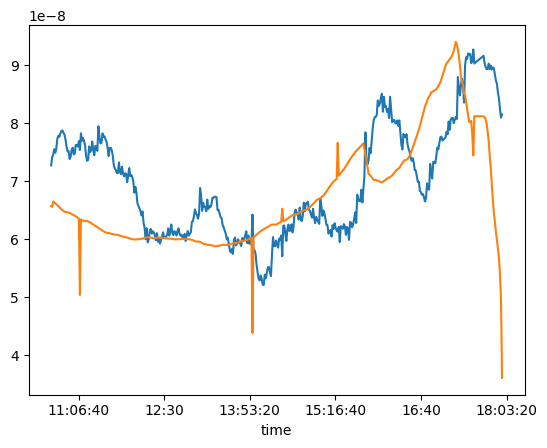

In [19]:
mean_vol_eod_preds=eurex.loc[X_test.index].mean_vol_eod_ssnl_adj*np.exp(y_pred)
mean_vol_eod_real=eurex.loc[X_test.index].mean_vol_eod
mean_vol_eod_preds.groupby(mean_vol_eod_preds.index.time).mean().plot()
mean_vol_eod_real.groupby(mean_vol_eod_preds.index.time).mean().plot()

<Axes: xlabel='time'>

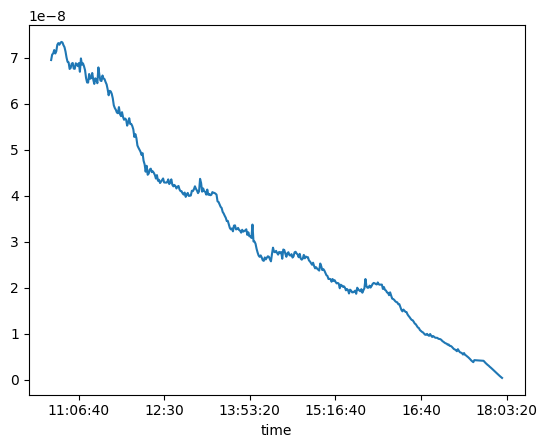

In [20]:
(mean_vol_eod_preds*(1-eurex.loc[X_test.index].time_p)).groupby(mean_vol_eod_preds.index.time).mean().plot()

<Axes: xlabel='time'>

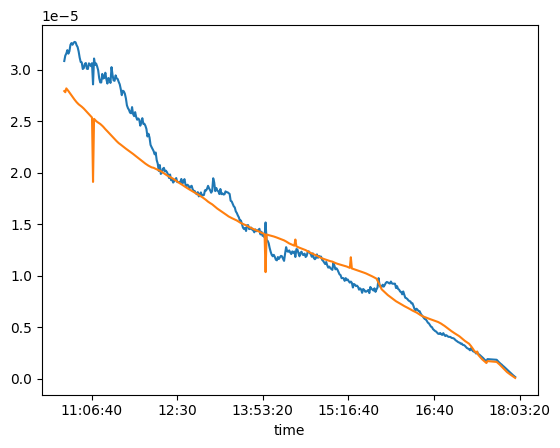

In [21]:
int_vol_preds=mean_vol_eod_preds*eurex.loc[X_test.index].count_to_eod
int_vol_real=mean_vol_eod_real*eurex.loc[X_test.index].count_to_eod
int_vol_preds.groupby(int_vol_preds.index.time).mean().plot()
int_vol_real.groupby(int_vol_preds.index.time).mean().plot()

In [29]:
np.max(np.array([0,1,2,4,5]))

5

In [36]:
np.arange(100,1000,100)

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

<Axes: xlabel='sigma'>

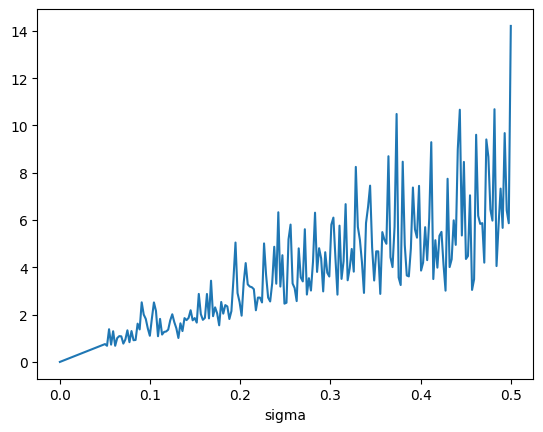

In [56]:
sigma=np.linspace(0.05,0.5,200)
N=np.arange(100,1000,200)
mu=0
sim_n=1000
ranges=np.zeros((sim_n*len(sigma),3))
for i in range(sim_n):
    for j in range(len(sigma)):
        for n in range(len(N)):
            white_noise=np.random.normal(mu,sigma[j],N[n])
            rw=np.cumsum(white_noise)
            #print(rw)
            max_rw=np.max(rw)
            min_rw=np.min(rw)
            ranges[i+j+n,0]=sigma[j]
            ranges[i+j+n,1]=N[n]
            ranges[i+j+n,2]=max_rw-min_rw



ranges=pd.DataFrame(ranges,columns=['sigma','delta_t','range'])
ranges.groupby('sigma').range.mean().plot()

<Axes: xlabel='delta_t'>

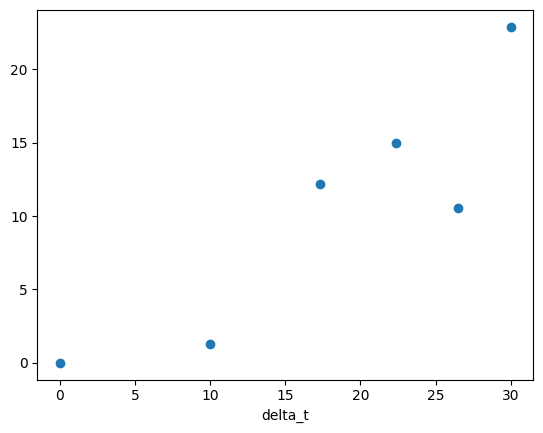

In [60]:
ranges.groupby(['delta_t']).range.mean().plot(style='o')


In [58]:
ranges['delta_t']=np.sqrt(ranges.delta_t)

<Axes: xlabel='time'>

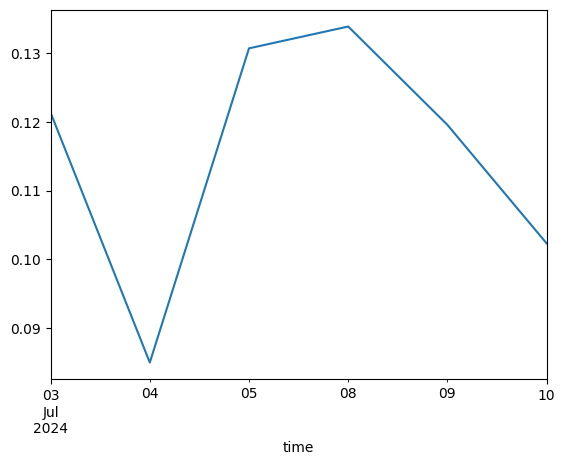

In [63]:
(np.sqrt(int_vol_real*480)).groupby(int_vol_preds.index.normalize()).first().plot()


<Axes: xlabel='time'>

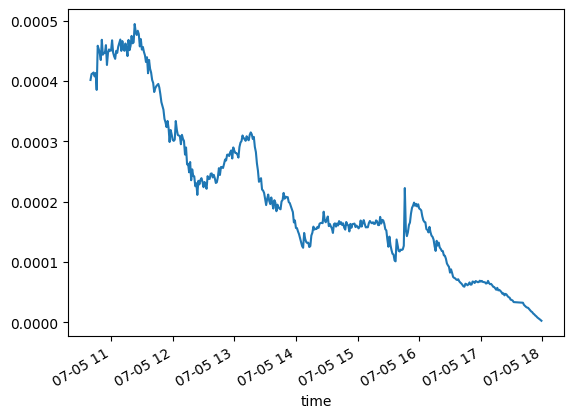

In [23]:
day="2024-07-05"
(int_vol_preds*np.sqrt(252)).loc[day].plot()
#int_vol_real.loc[day].plot()
